In [1]:
#default_exp familiarity

# The Differential Encoding Mechanism
We intend for the differential encoding mechanism we're integrating into CMR to directly differentiate the strength of memory for spaced repetitions of items relative to that of massed repetitions of items. 

But how exactly does the mechanism work? Here, we'll specify the mechanism and perform some demonstrations exploring:

1. How the mechanism modulates learning as familiarity and parameter values vary
2. How the mechanism shapes model representations under different conditions
3. How these modified model representations then shape simulated behavior

## The Mechanism

Lohnas & Kahana (2015) demonstrate that CMR realizes alternative accounts of the spacing effect -- the contextual variability and study-phase retrieval accounts. But the big idea of the deficient encoding hypothesis as an account of the spacing effect is that:
1. Item familiarity ("close acquaintance") impairs attention and memory of subsequent encoding.
2. Repeated experience of an item increases familiarity with that item
3. On the other hand, familiarity decreases with intervening experience, allowing better memory of repetitions

We're still exploring exactly how to implement this mechanism. However, at the moment we realize this mechanism through episode-by-episode modulation of $M^{CF}$ learning rate, much like how the primacy effect is enforced in the Morton & Polyn (2016) specification of CMR.

$$
\Delta M^{CF}_{exp} = \zeta_i \phi_i f_i c^{'}_i
$$

where

$$
\zeta_i = \zeta_s [1 - S(f_i, c_i)]
$$

With $S$ as the cosine similarity function and a familiarity_scale parameter $\zeta_s$ controlling the extent to which item familiarity scales learning.

In [2]:
# preferred linear function
familiarity = lambda familiarity_scale, similarity: np.multiply(1-similarity, familiarity_scale) + 1

# power law function
familiarity = lambda familiarity_scale, similarity: np.power(np.multiply(1-similarity, familiarity_scale) + 1, 3) + 1

# exponential function
familiarity = lambda familiarity_scale, similarity: np.power(familiarity_scale, 1-similarity)

In [3]:
from numba import njit
import numpy as np

@njit
def familiarity_weighting(familiarity_scale, similarity):
    return np.power(1 - similarity, familiarity_scale)

## How Do Values of $\zeta_i$ Vary?

Given the kinds of representation states that $f_i$ and $c_i$ can have under simulation of CMR and how cosine similarity works, $(S(f_i, c_i)$ always ranges in (0, 1). Furthermore, we enforce that for items encoded for the first time (and preserving the orthogonality assumption for item representations), familiarity always a neutral effect on learning (i.e., $\zeta_i = 1$). In theory, when $c_i$ and $f_i$ are equivalent, no learning happens. But in practice, the representations always differ at least a little. $\zeta_s$ is intended to control the extent to which item familiarity constrains learning. When $\zeta_s = 1$, the function is linear. At very high values of $\zeta_s$, the effect of familiarity on learning is neutral across all relevant similarity values. Alternatively, as $\zeta_s$ approaches zero, only completely unfamiliar items influence recall. 

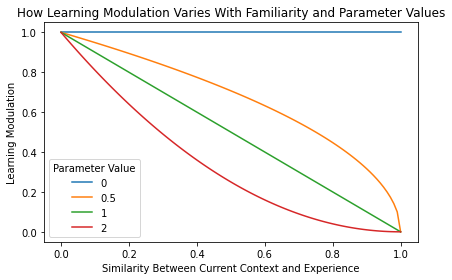

In [4]:
import numpy as np
import matplotlib.pyplot as plt

similarity_values = np.arange(0, 1.01, .01)

for familiarity_scale in[0, .5, 1, 2]:
    plt.plot(similarity_values, [familiarity_weighting(familiarity_scale, s) for s in similarity_values], label=str(familiarity_scale))

plt.title('How Learning Modulation Varies With Familiarity and Parameter Values')
plt.ylabel('Learning Modulation')
plt.xlabel('Similarity Between Current Context and Experience')
plt.legend(title='Parameter Value')
plt.tight_layout()
plt.show()

## How Do Values of $\zeta_i$ Configure Model Representations?
We know $\zeta_i$ modulates $\Delta M^{CF}_{exp}$ in study lists with item repetitions. In particular, it intends to reduce context-to-item associations in $M^{CF}$ corresponding to the repeated study item depending on the spacing between item presentations (but also other factors configuring item familiarity, like the rate of contextual drift).

We can visualize this effect by simulating processing of a study list with item repetitions using CMR with different parameter values, and then inspecting the summed support for recall of each item across possible contextual inputs in $M^{CF}$.

### Demo Configuration

In [5]:
from compmemlearn.models import Classic_CMR

# parameter values
free_parameters = [
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'familiarity_scale']

fit_values = [6.69941126e-01, 1.09189743e-01, 8.93439617e-01, 4.33712328e-03,
            3.07498806e-01, 3.63436921e-02, 9.46980497e+00, 9.45689916e+01,
            1.64802945e-02, 3.06620677e-01, 2.04345530e+00]

parameters = {free_parameters[i]:fit_values[i] for i in range(len(fit_values))}
parameters['sampling_rule'] = 0
parameters['delay_drift_rate'] = 0

# presentation scheme
# repeat the 3-indexed item at position 10, and the 10-index item at position 14
presentation = [0, 1, 2, 3, 4, 5, 6, 7, 3, 8, 9, 10, 10, 11, 12, 13, 14, 13, 15, 16]

# range of parameter values considered
scale_range =  [.5, 1, 1.75, 5]

### Sum Visualization

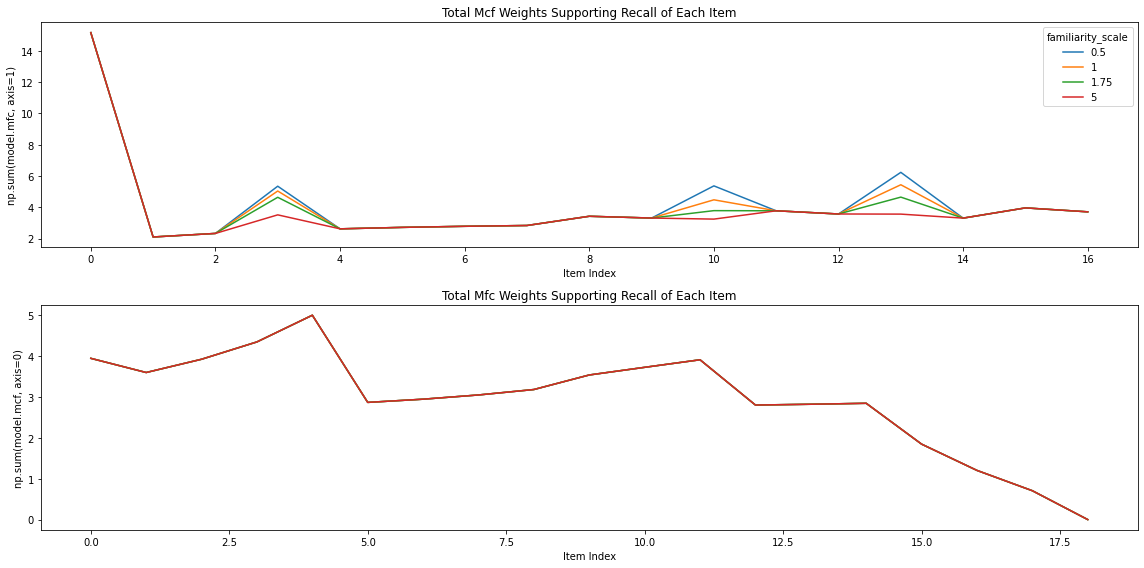

In [6]:
import seaborn as sns

f, (ax1, ax2) = plt.subplots(2, 1, sharey=False, figsize=(16, 8))

for scale in scale_range:
    
    test_params = parameters.copy()
    test_params['familiarity_scale'] = scale
    
    item_count = np.max(presentation)+1
    model = Classic_CMR(**{'item_count': item_count, 'presentation_count': len(presentation), **test_params})

    # simulate study events
    model.experience(np.eye(model.item_count, model.item_count)[presentation])

    #plot_states(model.mcf, 'Final Mcf')
    ax1.plot(np.arange(item_count), np.sum(model.mcf, axis=0), label=str(scale))
    ax2.plot(np.arange(item_count+2), np.sum(model.mfc, axis=0), label=str(scale))
    
ax1.legend(title='familiarity_scale')
ax1.set_title('Total Mcf Weights Supporting Recall of Each Item')
ax2.set_title('Total Mfc Weights Supporting Recall of Each Item')
ax1.set_xlabel('Item Index')
ax2.set_xlabel('Item Index')
ax2.set_ylabel('np.sum(model.mcf, axis=0)')
ax1.set_ylabel('np.sum(model.mfc, axis=1)')
plt.tight_layout()
plt.show()

### Matrix Visualization

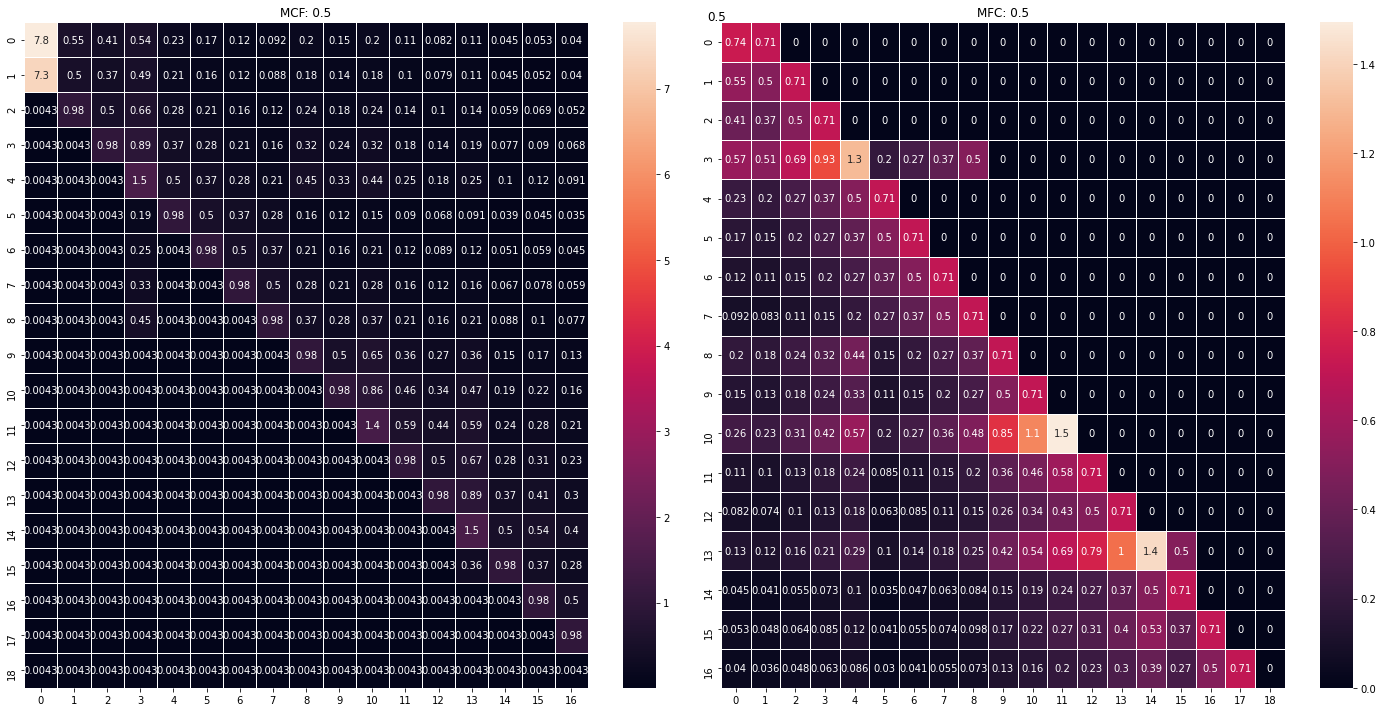

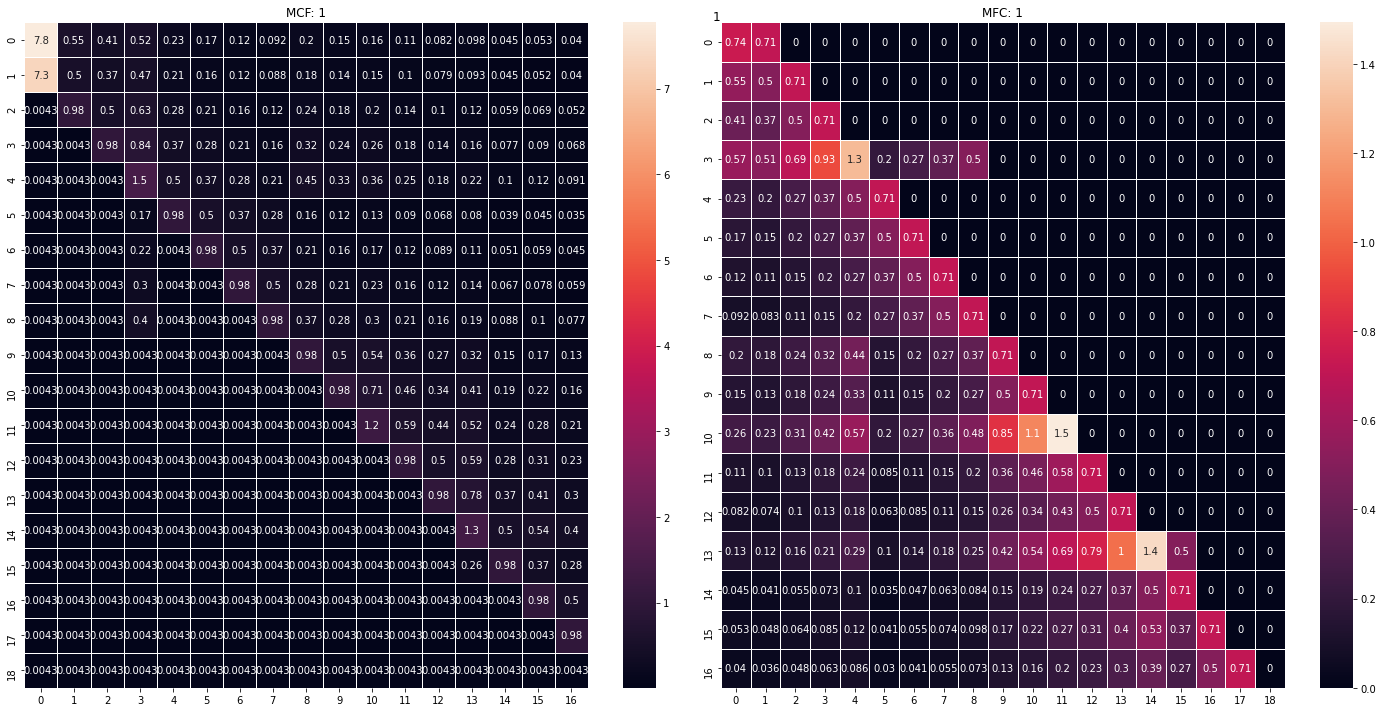

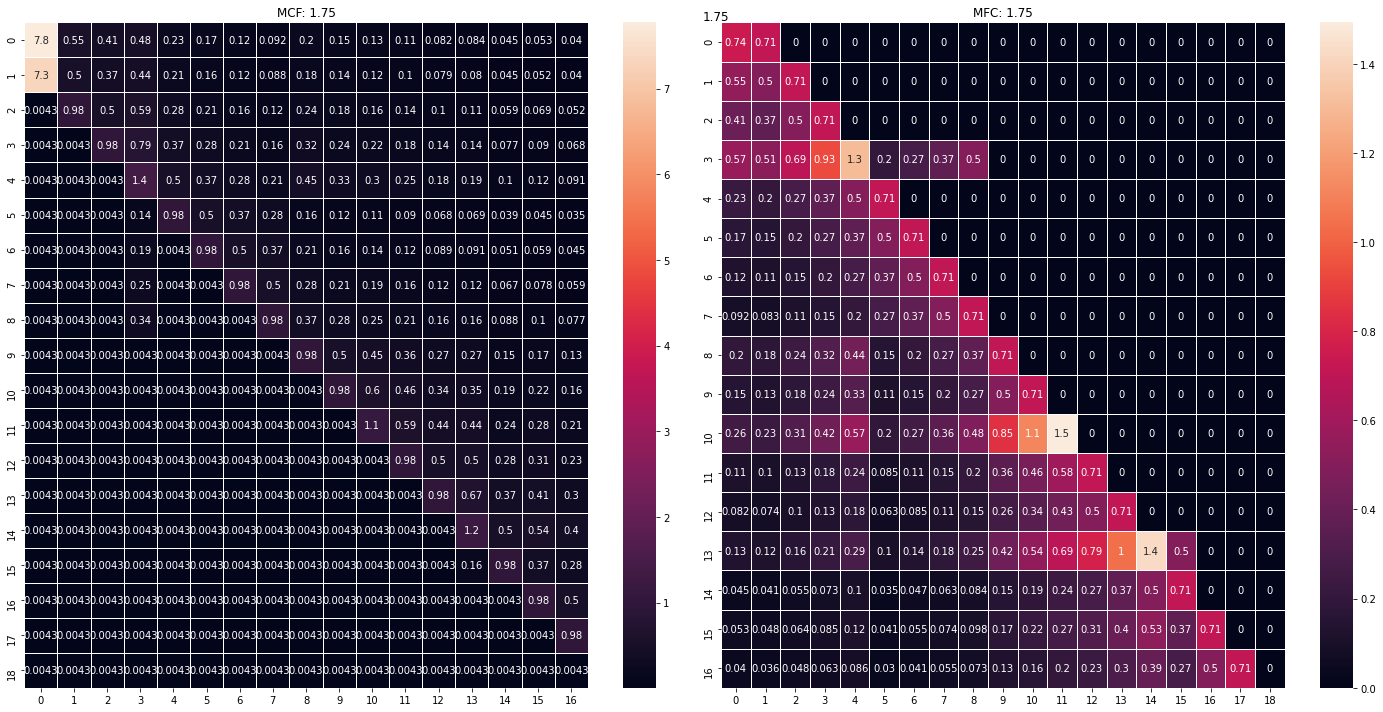

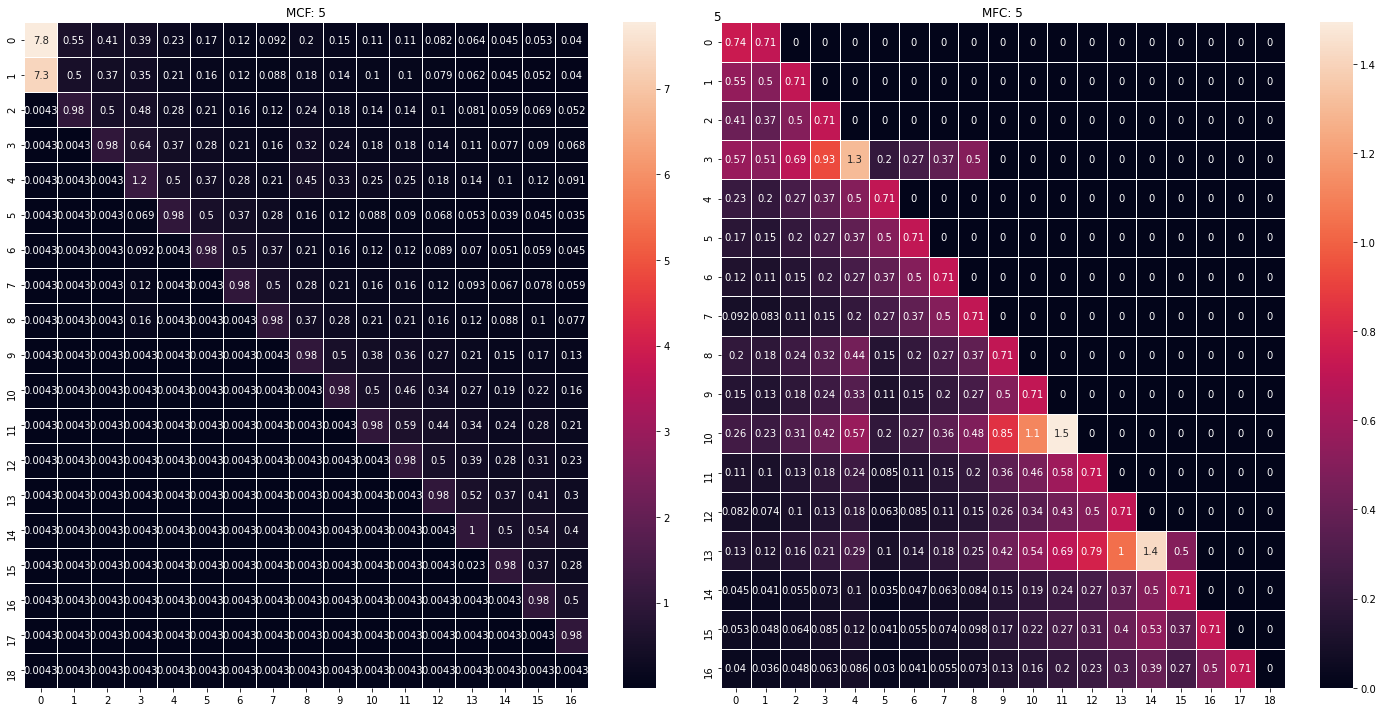

In [7]:
import seaborn as sns

regenerate_sim = True

if regenerate_sim:
    for scale in scale_range:

        f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(20, 10))
        
        test_params = parameters.copy()
        test_params['familiarity_scale'] = scale
        
        item_count = np.max(presentation)+1
        model = Classic_CMR(**{'item_count': item_count, 'presentation_count': len(presentation), **test_params})

        # simulate study events
        model.experience(np.eye(model.item_count, model.item_count)[presentation])

        #plot_states(model.mcf, 'Final Mcf')
        sns.heatmap(model.mcf, ax=ax1 ,annot=True, linewidths=.5)
        sns.heatmap(model.mfc, ax=ax2, annot=True, linewidths=.5)
        
        ax1.set_title('MCF: ' + str(scale))
        ax2.set_title('MFC: ' + str(scale))
        plt.tight_layout()
        plt.suptitle(str(scale))
        plt.show()

Later, values in $M^{CF}$ configure the activation of each item during recall as context evolves:

$$
a = M^{CF}c
$$

With the probability of recalling items based on their activation varying according to:

$$
P(i, j) = (1-P(stop, j))\frac{a^{\tau}_i}{\sum_{k}^{N}a^{\tau}_k}
$$

$\tau$ is thus another parameter configuring how influential deficient encoding is on predicted recalls; at high values of $\tau$, small differences in context-to-item associations encoded in $M^{CF}$ and retrievable given a state of $c$ drive stronger differences between items' probability of being recalled.

## How Do Values of $\zeta_s$ Configure the Spacing Effect?
We intend for $\zeta_s$ to control the distinction in learning between highly familiar and highly novel items. Greater values for the parameter should correspond to less learning for mass-repeated items relative to that of spaced-repeated items, but no difference in learning for singly-presented items. We'll demo this functionality using the trials presented by Lohnas & Kahana (2015) to study repetition memory.

In [8]:
from compmemlearn.datasets import prepare_lohnas2014_data
from compmemlearn.analyses import sim_recall_probability_by_lag

trials, events, list_length, presentations, list_types, rep_data, subjects = prepare_lohnas2014_data(
    '../../data/repFR.mat')

events.head()

,subject,list,item,input,output,study,recall,repeat,intrusion,condition
0,1,1,0,1,1.0,True,True,0,False,4
1,1,1,1,2,2.0,True,True,0,False,4
2,1,1,2,3,3.0,True,True,0,False,4
3,1,1,3,4,4.0,True,True,0,False,4
4,1,1,4,5,5.0,True,True,0,False,4


0.5
[0.17616752 0.36682143 0.40155357 0.41288095 0.42365476]
1
[0.17733929 0.36196429 0.39871429 0.41254762 0.42069048]
1.75
[0.1782585  0.35714286 0.393875   0.40771429 0.4152619 ]
5
[0.18071514 0.359      0.38367857 0.40203571 0.4040119 ]


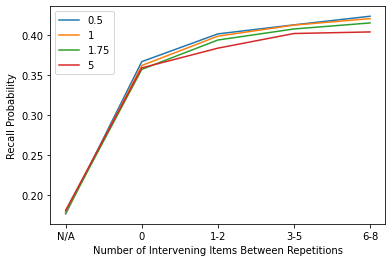

In [9]:
regenerate_sim = True

if regenerate_sim:
    for scale in scale_range:
        print(scale)
        
        test_params = parameters.copy()
        test_params['familiarity_scale'] = scale

        result = sim_recall_probability_by_lag(
            Classic_CMR, {'presentation_count': 40, **test_params}, 
            presentations[list_types==4], experiment_count=100)[-1]

        print(result)

        plt.plot(['N/A', '0', '1-2', '3-5', '6-8'], result, label=str(scale))

    plt.xlabel('Number of Intervening Items Between Repetitions')
    plt.ylabel('Recall Probability')
    plt.legend()
    plt.show()

## How Do Values of $\zeta_s$ Configure Predicted Lag-CRP, SPC, etc?

## Does CMR With Differential Encoding fit Better to Repetition Memory Data?
To find out, we'll fit CMR to the data presented by Lohnas & Kahana (2015) to study repetition memory, once freeing the familiarity_scale parameter and once fixing it to a value of 1. Then we'll compare the fits. If the model doesn't fit better, that's really bizarre.

In [10]:
from compmemlearn.fitting import cmr_rep_objective_function
from scipy.optimize import differential_evolution

In [11]:
regenerate_fit = True

base_cmr_free_parameters = [
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'delay_drift_rate']

if regenerate_fit:

    lb = np.finfo(float).eps
    ub = 1-np.finfo(float).eps

    base_cmr_bounds = [
        (lb, ub),
        (lb, ub),
        (lb, ub),
        (lb, ub),
        (lb, ub),
        (lb, ub),
        (lb, 100),
        (lb, 100),
        (lb, ub),
        (lb, 10),
        (lb, 10),
        (lb, ub)
    ]

    # cost function to be minimized
    # ours scales inversely with the probability that the data could have been 
    # generated using the specified parameters and our model
    selection = list_types > 0
    cost_function = cmr_rep_objective_function(
        trials[selection], presentations[selection], list_types[selection], list_length,
        {'sampling_rule': 0, 'familiarity_scale': 0}, base_cmr_free_parameters)

    base_cmr_result = differential_evolution(cost_function, base_cmr_bounds, disp=True)
    print(base_cmr_result)

else:

    pre_generated_fit = np.array([8.46039270e-01, 1.41515511e-01, 9.26644875e-01, 5.19631671e-02,
 7.73352199e-01, 3.08921464e-01, 3.87151355e+00, 9.40985410e+01,
 2.51622064e-02, 1.01411809e-01, 1.36958634e+00, 9.97475829e-01])
    pre_generated_fun = 60496.17650490797
    base_cmr_result = type(
        'result', (object,), {'x': pre_generated_fit, 'fun': pre_generated_fun})

print(base_cmr_result.x, base_cmr_result.fun)

differential_evolution step 1: f(x)= 70625.4
differential_evolution step 2: f(x)= 70625.4
differential_evolution step 3: f(x)= 70625.4
differential_evolution step 4: f(x)= 69275.5
differential_evolution step 5: f(x)= 69275.5
differential_evolution step 6: f(x)= 69251
differential_evolution step 7: f(x)= 66612
differential_evolution step 8: f(x)= 66585.9
differential_evolution step 9: f(x)= 66585.9
differential_evolution step 10: f(x)= 62483.6
differential_evolution step 11: f(x)= 62483.6
differential_evolution step 12: f(x)= 62483.6
differential_evolution step 13: f(x)= 62483.6
differential_evolution step 14: f(x)= 62483.6
differential_evolution step 15: f(x)= 62483.6
differential_evolution step 16: f(x)= 62483.6
differential_evolution step 17: f(x)= 62377.5
differential_evolution step 18: f(x)= 61709.7
differential_evolution step 19: f(x)= 61709.7
differential_evolution step 20: f(x)= 61480.1
differential_evolution step 21: f(x)= 61480.1
differential_evolution step 22: f(x)= 61480.1
d

In [12]:
regenerate_fit = True

cmrde_free_parameters = [
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'delay_drift_rate',
    'familiarity_scale']

if regenerate_fit:
    lb = np.finfo(float).eps
    ub = 1-np.finfo(float).eps

    cmrde_bounds = [
        (lb, ub),
        (lb, ub),
        (lb, ub),
        (lb, ub),
        (lb, ub),
        (lb, ub),
        (lb, 100),
        (lb, 100),
        (lb, ub),
        (lb, 10),
        (lb, 10),
        (lb, ub),
        (lb, 100),
    ]

    # cost function to be minimized
    # ours scales inversely with the probability that the data could have been 
    # generated using the specified parameters and our model
    selection = list_types > 0
    cost_function = cmr_rep_objective_function(
        trials[selection], presentations[selection], list_types[selection], list_length,
        {'sampling_rule': 0}, cmrde_free_parameters)

    cmrde_result = differential_evolution(cost_function, cmrde_bounds, disp=True)

else:

    pre_generated_fit = np.array([7.85303159e-01, 1.95274436e-01, 9.08367438e-01, 2.21641865e-01,
 1.00000000e+00, 3.28060377e-01, 2.12336822e+00, 7.53370592e-01,
 2.51647175e-02, 1.01405100e-01, 3.21638816e+00, 9.91252027e-01,
 2.83993602e+01])
    pre_generated_fun = 60083.5603914034
    cmrde_result = type('result', (object,), {'x': pre_generated_fit, 'fun': pre_generated_fun})

print(cmrde_result.x, cmrde_result.fun)

differential_evolution step 1: f(x)= 95773.4
differential_evolution step 2: f(x)= 86529.3
differential_evolution step 3: f(x)= 72314.9
differential_evolution step 4: f(x)= 70657.4
differential_evolution step 5: f(x)= 70657.4
differential_evolution step 6: f(x)= 70240.5
differential_evolution step 7: f(x)= 69245.9
differential_evolution step 8: f(x)= 68737.9
differential_evolution step 9: f(x)= 65431.6
differential_evolution step 10: f(x)= 65431.6
differential_evolution step 11: f(x)= 65431.6
differential_evolution step 12: f(x)= 65431.6
differential_evolution step 13: f(x)= 62336.2
differential_evolution step 14: f(x)= 62336.2
differential_evolution step 15: f(x)= 62336.2
differential_evolution step 16: f(x)= 62336.2
differential_evolution step 17: f(x)= 60984.2
differential_evolution step 18: f(x)= 60984.2
differential_evolution step 19: f(x)= 60984.2
differential_evolution step 20: f(x)= 60984.2
differential_evolution step 21: f(x)= 60984.2
differential_evolution step 22: f(x)= 60984

In [13]:
def aic(k, likelihood):
    return 2*k + 2*likelihood

In [14]:
aic(11, 60842.73)

121707.46

In [15]:
aic(12, 60656.75)

121337.5

In [16]:
np.exp((121337.5 - 121707.46)/2)

4.615372281957718e-81

## Does CMR with Differential Encoding Generalize Better Across List Types?
Fit each version of CMR to conditions 2, 3, and 4. Then compare predictions about behavior in the control condition. Look at overall predictive accuracy, serial position curve, lag-CRP, and probability of first recall.

### Base CMR Generalization

In [17]:
regenerate_fit = True

base_cmr_free_parameters = [
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'delay_drift_rate']

if regenerate_fit:

    lb = np.finfo(float).eps
    ub = 1-np.finfo(float).eps

    base_cmr_bounds = [
        (lb, ub),
        (lb, ub),
        (lb, ub),
        (lb, ub),
        (lb, ub),
        (lb, ub),
        (lb, 100),
        (lb, 100),
        (lb, ub),
        (lb, 10),
        (lb, 10),
        (lb, ub),
    ]

    # cost function to be minimized
    # ours scales inversely with the probability that the data could have been 
    # generated using the specified parameters and our model
    selection = list_types > 1
    cost_function = cmr_rep_objective_function(
        trials[selection], presentations[selection], list_types[selection], list_length,
        {'sampling_rule': 0, 'familiarity_scale': 0}, base_cmr_free_parameters)

    base_cmr_result = differential_evolution(cost_function, base_cmr_bounds, disp=True)
    print(base_cmr_result)

else:

    pre_generated_fit = np.array([8.38649798e-01, 1.35961538e-01, 9.15529431e-01, 8.30157436e-02,
 8.63507483e-01, 2.75546629e-01, 4.13219209e+00, 4.02971707e+01,
 2.18409687e-02, 1.21186925e-01, 1.56900962e+00, 9.97783584e-01])
    pre_generated_fun = 41480.48043502652
    base_cmr_result = type('result', (object,), {'x': pre_generated_fit, 'fun': pre_generated_fun})

print(base_cmr_result.x, base_cmr_result.fun)

differential_evolution step 1: f(x)= 50622.3
differential_evolution step 2: f(x)= 50622.3
differential_evolution step 3: f(x)= 50622.3
differential_evolution step 4: f(x)= 49170.8
differential_evolution step 5: f(x)= 48344.7
differential_evolution step 6: f(x)= 48344.7
differential_evolution step 7: f(x)= 45800
differential_evolution step 8: f(x)= 45800
differential_evolution step 9: f(x)= 45800
differential_evolution step 10: f(x)= 45800
differential_evolution step 11: f(x)= 45800
differential_evolution step 12: f(x)= 45800
differential_evolution step 13: f(x)= 44218.9
differential_evolution step 14: f(x)= 42946.6
differential_evolution step 15: f(x)= 42946.6
differential_evolution step 16: f(x)= 42946.6
differential_evolution step 17: f(x)= 42946.6
differential_evolution step 18: f(x)= 42946.6
differential_evolution step 19: f(x)= 42753.3
differential_evolution step 20: f(x)= 42753.3
differential_evolution step 21: f(x)= 42753.3
differential_evolution step 22: f(x)= 42753.3
different

### CMR-DE Generalization

In [18]:
regenerate_fit = True

cmrde_free_parameters = [
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'delay_drift_rate',
    'familiarity_scale']

if regenerate_fit:

    lb = np.finfo(float).eps
    ub = 1-np.finfo(float).eps

    cmrde_bounds = [
        (lb, ub),
        (lb, ub),
        (lb, ub),
        (lb, ub),
        (lb, ub),
        (lb, ub),
        (lb, 100),
        (lb, 100),
        (lb, ub),
        (lb, 10),
        (lb, 10),
        (lb, ub),
        (lb, 100),
    ]

    # cost function to be minimized
    # ours scales inversely with the probability that the data could have been 
    # generated using the specified parameters and our model
    selection = list_types > 1
    cost_function = cmr_rep_objective_function(
        trials[selection], presentations[selection], list_types[selection], list_length,
        {'sampling_rule': 0}, cmrde_free_parameters)

    cmrde_result = differential_evolution(cost_function, cmrde_bounds, disp=True)

else:

    pre_generated_fit = np.array([8.02897453e-01, 2.28239870e-01, 8.98772623e-01, 4.43103475e-01,
        1.00000000e+00, 3.86645895e-01, 1.30164297e+00, 7.83282934e+01,
        2.18380435e-02, 1.21197226e-01, 5.71602759e+00, 9.93387724e-01,
        6.17047148e+01])

    pre_generated_fun = 41389.442594323686
    cmrde_result = type('result', (object,), {'x': pre_generated_fit, 'fun': pre_generated_fun})

print(cmrde_result.x, cmrde_result.fun)

differential_evolution step 1: f(x)= 116009
differential_evolution step 2: f(x)= 69180.4
differential_evolution step 3: f(x)= 53176.2
differential_evolution step 4: f(x)= 51121.3
differential_evolution step 5: f(x)= 50715.3
differential_evolution step 6: f(x)= 47900.3
differential_evolution step 7: f(x)= 47900.3
differential_evolution step 8: f(x)= 47176.9
differential_evolution step 9: f(x)= 47176.9
differential_evolution step 10: f(x)= 47176.9
differential_evolution step 11: f(x)= 46372.2
differential_evolution step 12: f(x)= 44762.2
differential_evolution step 13: f(x)= 44762.2
differential_evolution step 14: f(x)= 44676.8
differential_evolution step 15: f(x)= 44676.8
differential_evolution step 16: f(x)= 44376.5
differential_evolution step 17: f(x)= 43908
differential_evolution step 18: f(x)= 42489
differential_evolution step 19: f(x)= 42489
differential_evolution step 20: f(x)= 42489
differential_evolution step 21: f(x)= 42372.6
differential_evolution step 22: f(x)= 42372.6
differ

### True Fit

In [19]:
regenerate_fit = True

true_cmr_free_parameters = [
    'encoding_drift_rate',
    'delay_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'familiarity_scale']

if regenerate_fit:

    lb = np.finfo(float).eps
    ub = 1-np.finfo(float).eps

    true_cmr_bounds = [
        (lb, ub),
        (lb, ub),
        (lb, ub),
        (lb, ub),
        (lb, ub),
        (lb, ub),
        (lb, ub),
        (lb, 100),
        (lb, 100),
        (lb, ub),
        (lb, 10),
        (lb, 10),
        (lb, 100),
    ]

    # cost function to be minimized
    # ours scales inversely with the probability that the data could have been 
    # generated using the specified parameters and our model
    selection = list_types == 1
    cost_function = cmr_rep_objective_function(
        trials[selection], presentations[selection], list_types[selection], list_length,
        {'sampling_rule': 0, 'familiarity_scale': 0}, true_cmr_free_parameters)

    true_cmr_result = differential_evolution(cost_function, true_cmr_bounds, disp=True)
    print(true_cmr_result)

else:

    pre_generated_fit = np.array([7.49829040e-01, 9.40879905e-01, 3.88458189e-01, 9.18502901e-01,
 7.36673074e-01, 7.32671247e-01, 7.10135255e-01, 6.24997034e-01,
 1.25823087e+01, 2.36135876e-02, 9.12404486e-02, 9.52853899e+00,
 7.59066815e+01])
 
    pre_generated_fun = 18763.341070798982
    true_cmr_result = type('result', (object,), {'x': pre_generated_fit, 'fun': pre_generated_fun})

print(true_cmr_result.x, true_cmr_result.fun)

differential_evolution step 1: f(x)= 39845.9
differential_evolution step 2: f(x)= 30705.4
differential_evolution step 3: f(x)= 22113
differential_evolution step 4: f(x)= 21733.5
differential_evolution step 5: f(x)= 21733.5
differential_evolution step 6: f(x)= 19637.2
differential_evolution step 7: f(x)= 19637.2
differential_evolution step 8: f(x)= 19637.2
differential_evolution step 9: f(x)= 19637.2
differential_evolution step 10: f(x)= 19637.2
differential_evolution step 11: f(x)= 19637.2
differential_evolution step 12: f(x)= 19148.9
differential_evolution step 13: f(x)= 19148.9
differential_evolution step 14: f(x)= 19076.5
differential_evolution step 15: f(x)= 19076.5
differential_evolution step 16: f(x)= 19060.9
differential_evolution step 17: f(x)= 19060.9
differential_evolution step 18: f(x)= 19060.9
differential_evolution step 19: f(x)= 18840.2
differential_evolution step 20: f(x)= 18840.2
differential_evolution step 21: f(x)= 18840.2
differential_evolution step 22: f(x)= 18840.2

### Comparing Predicted Recall Sequences in Held-Out Condition

In [20]:
from compmemlearn.fitting import cmr_rep_likelihood

# build parameter dict from base_cmr_result
base_cmr_params = {base_cmr_free_parameters[i]: base_cmr_result.x[i] for i in range(len(base_cmr_free_parameters))}
base_cmr_params['sampling_rule'] = 0
base_cmr_params['familiarity_scale'] = 0

# build parameter dict from cmrde_result
cmrde_params = {cmrde_free_parameters[i]: cmrde_result.x[i] for i in range(len(cmrde_free_parameters))}
cmrde_params['sampling_rule'] = 0

# build parameter dict from true_cmr_result
true_cmr_params = {true_cmr_free_parameters[i]: true_cmr_result.x[i] for i in range(len(true_cmr_free_parameters))}
true_cmr_params['sampling_rule'] = 0
true_cmr_params['familiarity_scale'] =0

# track the likelihood of the held out data under each parameter configuration
selection = list_types == 1
print(cmr_rep_likelihood(
        trials[selection], presentations[selection], list_types[selection], list_length, **base_cmr_params))

print(cmr_rep_likelihood(
        trials[selection], presentations[selection], list_types[selection], list_length, **cmrde_params))

print(cmr_rep_likelihood(
        trials[selection], presentations[selection], list_types[selection], list_length, **true_cmr_params))

19269.904933888145
19023.337643031948
18763.602986465423


### Comparing Predicted Summary Statistics in Held-Out Condition

In [21]:
def extended_apply_and_concatenate(function, dfs, contrast_name='contrast', labels='AB'):
    """
    Concatenates the results of a function applied to passed dataframes and creates a new column identifying the contrast.
    """
    return pd.concat([function(df) for df in dfs], keys=labels, names=[contrast_name]).reset_index()

In [22]:
from compmemlearn.datasets import prepare_lohnas2014_data, simulate_data
from psifr import fr
import pandas as pd

base_model = Classic_CMR(
    **{**{'item_count': list_length, 'presentation_count': list_length, 'sampling_rule': 0},
    **{base_cmr_free_parameters[i]:base_cmr_result.x[i] for i in range(len(base_cmr_result.x))}})

de_model = Classic_CMR(
    **{**{'item_count': list_length, 'presentation_count': list_length, 'sampling_rule': 0},
    **{cmrde_free_parameters[i]:cmrde_result.x[i] for i in range(len(cmrde_result.x))}})

true_model = Classic_CMR(
    **{**{'item_count': list_length, 'presentation_count': list_length, 'sampling_rule': 0},
    **{true_cmr_free_parameters[i]:true_cmr_result.x[i] for i in range(len(true_cmr_result.x))}})

base_df = simulate_data(base_model, 1000)
de_df = simulate_data(de_model, 1000)
true_df = simulate_data(true_model, 1000)

dfs = [base_df, de_df, true_df, events.loc[events.condition == 1]]
labels = ['CMR', 'CMR-DE', 'Fitted Directly', 'Data']

spc = extended_apply_and_concatenate(fr.spc, dfs, contrast_name='source', labels=labels)
lag_crp = extended_apply_and_concatenate(fr.lag_crp, dfs, contrast_name='source', labels=labels)
pfr = extended_apply_and_concatenate(fr.pnr, dfs, contrast_name='source', labels=labels)
pfr = pfr.query('output <= 1')

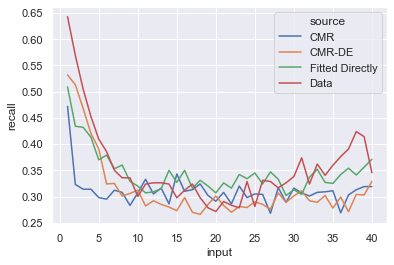

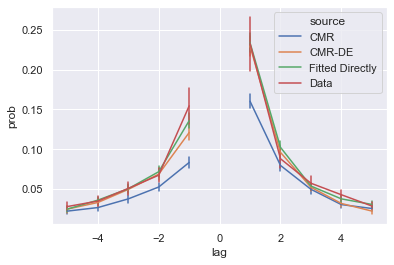

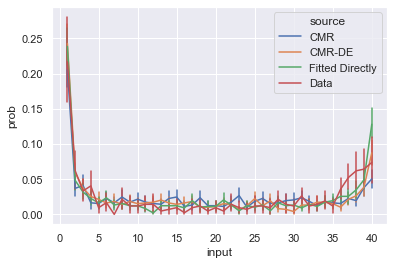

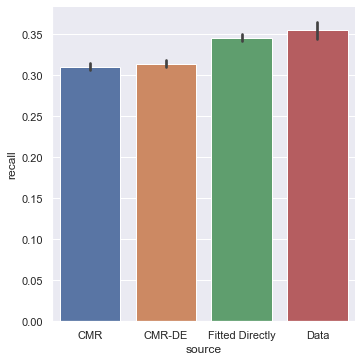

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")

sns.lineplot(data=spc, x='input', y='recall', err_style='bars', hue='source', legend=True, ci=False)
plt.show()

max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

sns.lineplot(data=lag_crp.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(data=lag_crp.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=True)
plt.show()

sns.lineplot(data=pfr, x='input', y='prob', err_style='bars', hue='source', legend=True)
plt.show()

sns.catplot(data=spc, x='source', y='recall', kind='bar')
plt.show()
